In [ ]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.6 MB/s eta 0:00:00


In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.probability import FreqDist

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CS135_Project_A/

/content/drive/MyDrive/CS135_Project_A


In [ ]:
!pwd

/content/drive/MyDrive/CS135_Project_A


In [ ]:
x_train_df = pd.read_csv('data_reviews/x_train.csv')
y_train_df = pd.read_csv('data_reviews/y_train.csv')
x_test_df = pd.read_csv('data_reviews/x_test.csv')

In [ ]:
N, n_cols = x_train_df.shape
print("Shape of x_train_df: (%d, %d)" % (N,n_cols))
print("Shape of y_train_df: %s" % str(y_train_df.shape))
N, n_cols = x_test_df.shape
print("Shape of x_test_df: (%d, %d)" % (N,n_cols))

Shape of x_train_df: (2400, 2)
Shape of y_train_df: (2400, 1)
Shape of x_test_df: (600, 2)


In [ ]:
x_train_df.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


In [ ]:
y_train_df.head()

,is_positive_sentiment
0,0
1,0
2,0
3,0
4,0


In [ ]:
# Print out the first five rows and last five rows
tr_text_list = x_train_df['text'].values.tolist()
rows = np.arange(0, 5)
for row_id in rows:
  text = tr_text_list[row_id]
  print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

print("...")
rows = np.arange(N - 5, N)
for row_id in rows:
  text = tr_text_list[row_id]
  print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

row     0 | y = 0 | Oh and I forgot to also mention the weird color effect it has on your phone.
row     1 | y = 0 | THAT one didn't work either.
row     2 | y = 0 | Waste of 13 bucks.
row     3 | y = 0 | Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with.
row     4 | y = 0 | None of the three sizes they sent with the headset would stay in my ears.
...
row   595 | y = 1 | So I bought about 10 of these and saved alot of money.
row   596 | y = 1 | You'll love how thin it is.
row   597 | y = 1 | Magical Help.
row   598 | y = 1 | My Sanyo has survived dozens of drops on blacktop without ill effect.
row   599 | y = 1 | Clear Skype Calls, Long Battery Life, Long Range.


In [ ]:
def check_spell(text):
    spell = SpellChecker()
    words = word_tokenize(text)
    misspelled = spell.unknown(words)

    corrected_words = []
    for word in words:
        corrected_word = spell.correction(word)
        if corrected_word:
            corrected_words.append(corrected_word)
        else:
            corrected_words.append(word)

    corrected_text = ' '.join(corrected_words)
    return corrected_text

In [ ]:
def remove_stop_words(text):
  tokens = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word for word in tokens if word not in stop_words]
  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

In [ ]:
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

In [ ]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

In [ ]:
x_train_df['text'] = x_train_df['text'].str.lower()
x_train_df['text'] = x_train_df['text'].apply(check_spell)
#x_train_df['text'] = x_train_df['text'].apply(remove_stop_words)
x_train_df['text'] = x_train_df['text'].apply(remove_punctuation)
#x_train_df['text'] = x_train_df['text'].apply(remove_numbers)

In [ ]:
x_test_df['text'] = x_test_df['text'].str.lower()
x_test_df['text'] = x_test_df['text'].apply(check_spell)
#x_test_df['text'] = x_test_df['text'].apply(remove_stop_words)
x_test_df['text'] = x_test_df['text'].apply(remove_punctuation)
#x_test_df['text'] = x_test_df['text'].apply(remove_numbers)

In [ ]:
tr_text_list = x_train_df['text'].values.tolist()

In [ ]:
def find_freq_words(text, flag, n):

    words = word_tokenize(text)
    fdist = FreqDist(words)

    df_fdist = pd.DataFrame({'Word': fdist.keys(),
                             'Frequency': fdist.values()})
    df_fdist = df_fdist.sort_values(by='Frequency', ascending = flag)

    freq_words_list = list(df_fdist['Word'][0:n])

    return freq_words_list

In [ ]:
most_freq_words = find_freq_words(" ".join(tr_text_list), False, 15)
most_freq_words

['the',
 'i',
 'and',
 'is',
 'a',
 'it',
 'to',
 'this',
 'of',
 'not',
 'was',
 'in',
 'for',
 'that',
 'with']

In [ ]:
def remove_freq_words(text, frequent_list):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in frequent_list])

In [ ]:
#x_train_df['text'] = x_train_df['text'].apply(remove_freq_words, frequent_list = most_freq_words)

In [ ]:
def remove_short_words(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if len(word) > 2])

In [ ]:
x_train_df['text'] = x_train_df['text'].apply(remove_short_words)

In [ ]:
x_test_df['text'] = x_test_df['text'].apply(remove_short_words)

In [ ]:
# Print out the first five rows and last five rows
tr_text_list = x_train_df['text'].values.tolist()
rows = np.arange(0, 5)
for row_id in rows:
  text = tr_text_list[row_id]
  print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

print("...")
rows = np.arange(N - 5, N)
for row_id in rows:
  text = tr_text_list[row_id]
  print("row %5d | y = %d | %s" % (row_id, y_train_df.values[row_id,0], text))

row     0 | y = 0 | and forgot also mention the weird color effect has your phone
row     1 | y = 0 | that one did not work either
row     2 | y = 0 | waste bucks
row     3 | y = 0 | product useless since does not have enough charging current charge the cellphones was planning use with
row     4 | y = 0 | none the three sizes they sent with the headset would stay ears
...
row   595 | y = 1 | bought about these and saved lot money
row   596 | y = 1 | you all love how thin
row   597 | y = 1 | magical help
row   598 | y = 1 | santo has survived dozens drops blacktop without ill effect
row   599 | y = 1 | clear skype calls long battery life long range


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(x_train_df['text'])
print(f"Shape of X: {X.shape}")

Shape of X: (2400, 4391)


In [ ]:
x_train = X.toarray()
print(x_train.shape)
print(x_train)

(2400, 4391)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
y_train = y_train_df.values.ravel()
print(y_train.shape)
print(y_train)

(2400,)
[0 0 0 ... 1 1 1]


In [ ]:
X = vectorizer.transform(x_test_df['text'])
print(f"Shape of X: {X.shape}")

Shape of X: (600, 4391)


In [ ]:
x_test = X.toarray()
print(x_test.shape)
print(x_test)

(600, 4391)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
np.random.seed(0)
n_features = x_train.shape[1]

hidden_units = [8, 16, 32, 64, 128, 256, 512]
K_values = [7, 8, 9, 10]

train_auc_matrix = np.zeros((len(hidden_units), len(K_values)))
validation_auc_matrix = np.zeros((len(hidden_units), len(K_values)))

for i, K in enumerate(K_values):
    kf = KFold(n_splits=K, shuffle=True, random_state=42)

    for j, units in enumerate(hidden_units):
        model = Sequential()
        model.add(Dense(units, input_dim=n_features, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

        train_auc_scores = []
        validation_auc_scores = []

        for train_idx, test_idx in kf.split(x_train):
            x_train_s, y_train_s = x_train[train_idx], y_train[train_idx]
            x_test_s, y_test_s = x_train[test_idx], y_train[test_idx]

            model.fit(x_train_s, y_train_s, epochs=10, batch_size=32, verbose=0)
            y_train_pred = model.predict(x_train_s)
            y_test_pred = model.predict(x_test_s)

            train_auc = roc_auc_score(y_train_s, y_train_pred)
            validation_auc = roc_auc_score(y_test_s, y_test_pred)

            train_auc_scores.append(train_auc)
            validation_auc_scores.append(validation_auc)

        train_avg_auc = np.mean(train_auc_scores)
        validation_avg_auc = np.mean(validation_auc_scores)

        train_auc_matrix[j, i] = train_avg_auc
        validation_auc_matrix[j, i] = validation_avg_auc
        print(f"Hidden Units: {units}, k: {K}, train_score: {train_auc_matrix[j, i]:.5f}, validation_score: {validation_auc_matrix[j, i]:.5f}")

11/11 [==============================] - 0s 2ms/step
Hidden Units: 8, k: 7, train_score: 0.97568, validation_score: 0.89463
11/11 [==============================] - 0s 2ms/step
Hidden Units: 16, k: 7, train_score: 0.98218, validation_score: 0.89880
11/11 [==============================] - 0s 2ms/step
Hidden Units: 32, k: 7, train_score: 0.98659, validation_score: 0.90023
11/11 [==============================] - 0s 3ms/step
Hidden Units: 64, k: 7, train_score: 0.99085, validation_score: 0.90205
11/11 [==============================] - 0s 3ms/step
Hidden Units: 128, k: 7, train_score: 0.99096, validation_score: 0.89830
11/11 [==============================] - 0s 5ms/step
Hidden Units: 256, k: 7, train_score: 0.98951, validation_score: 0.89729
11/11 [==============================] - 0s 12ms/step
Hidden Units: 512, k: 7, train_score: 0.98621, validation_score: 0.89374
10/10 [==============================] - 0s 3ms/step
Hidden Units: 8, k: 8, train_score: 0.97813, validation_score: 0.8986

In [ ]:
train_auc_df = pd.DataFrame(train_auc_matrix)
train_auc_df.columns = K_values
train_auc_df['Avg'] = train_auc_df.mean(axis=1)
train_auc_df['Hidden_Units'] = hidden_units
train_auc_df.head()

,7,8,9,10,Avg,Hidden_Units
0,0.975679,0.978131,0.980964,0.982200,0.979244,8
1,0.982185,0.985898,0.985049,0.985662,0.984698,16
2,0.986593,0.988934,0.989800,0.990285,0.988903,32
3,0.990852,0.990487,0.991253,0.992988,0.991395,64
4,0.990963,0.992211,0.992615,0.993425,0.992304,128


In [ ]:
validation_auc_df = pd.DataFrame(validation_auc_matrix)
validation_auc_df.columns = K_values
validation_auc_df['Avg'] = validation_auc_df.mean(axis=1)
validation_auc_df['Hidden_Units'] = hidden_units
validation_auc_df.head()

,7,8,9,10,Avg,Hidden_Units
0,0.894634,0.898598,0.898379,0.901407,0.898255,8
1,0.898804,0.900322,0.899897,0.902356,0.900345,16
2,0.900233,0.900758,0.900786,0.902914,0.901173,32
3,0.902054,0.902082,0.899896,0.903176,0.901802,64
4,0.898305,0.899006,0.901683,0.898689,0.899421,128


In [ ]:
columns_list = K_values + ['Avg']

for column in columns_list:
    max_value = validation_auc_df[column].max()
    max_row = validation_auc_df[validation_auc_df[column] == max_value]
    print(f"Maximum value in {column}:")
    print(max_row[[column, 'Hidden_Units']])
    print("=" * 20)

Maximum value in 7:
          7  Hidden_Units
3  0.902054            64
Maximum value in 8:
          8  Hidden_Units
3  0.902082            64
Maximum value in 9:
          9  Hidden_Units
4  0.901683           128
Maximum value in 10:
         10  Hidden_Units
3  0.903176            64
Maximum value in Avg:
        Avg  Hidden_Units
3  0.901802            64


In [ ]:
max_index = validation_auc_df['Avg'].idxmax()
print(f"Max Cross Validation Score: {validation_auc_df['Avg'].max():.5f}")
best_units = hidden_units[max_index]
print("Selected Parameters:")
print(best_units)

Max Cross Validation Score: 0.90180
Selected Parameters:
64


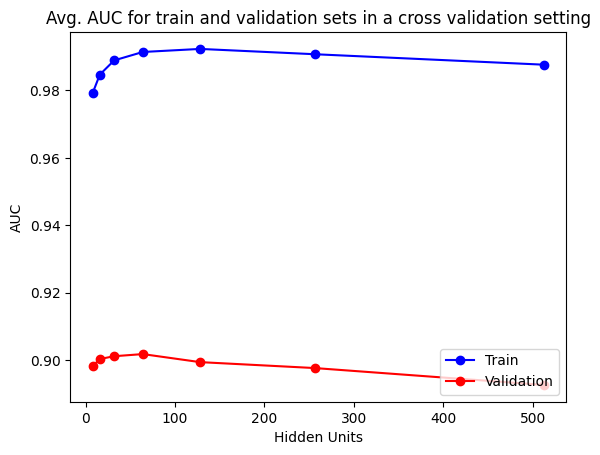

In [ ]:
plt.clf()

plt.plot(train_auc_df['Hidden_Units'], train_auc_df['Avg'], 'bo-', label='Train')
plt.plot(validation_auc_df['Hidden_Units'], validation_auc_df['Avg'], 'ro-', label='Validation')

plt.xlabel("Hidden Units")
plt.ylabel('AUC')
plt.title('Avg. AUC for train and validation sets in a cross validation setting')
plt.legend(loc='lower right')

plt.show()

<Figure size 640x480 with 0 Axes>

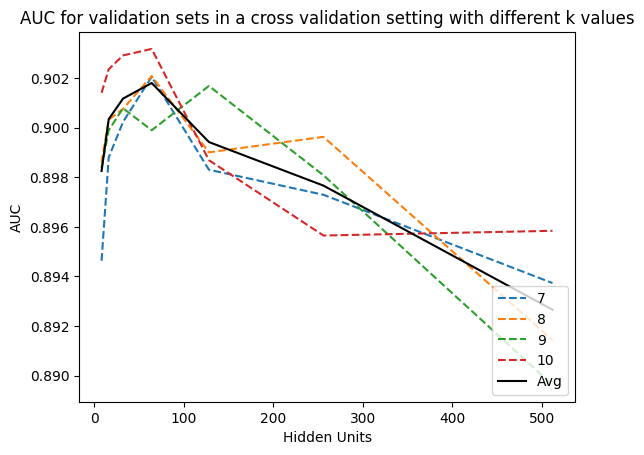

In [ ]:
plt.clf()

y = validation_auc_df.columns[(validation_auc_df.columns != 'Hidden_Units')]
ax = validation_auc_df.plot(x='Hidden_Units', y=y, linestyle='dashed')

for line, column in zip(ax.lines, validation_auc_df.columns):
    if column == 'Avg':
        line.set_linestyle('solid')
        line.set_color('black')

plt.xlabel("Hidden Units")
plt.ylabel('AUC')
plt.title('AUC for validation sets in a cross validation setting with different k values')
plt.legend(loc='lower right')

plt.show()

In [ ]:
np.random.seed(0)
model = Sequential()
model.add(Dense(best_units, input_dim=n_features, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
75/75 [==============================] - 1s 7ms/step - loss: 0.8686 - auc: 0.7809
Epoch 2/10
75/75 [==============================] - 0s 6ms/step - loss: 0.6690 - auc: 0.8765
Epoch 3/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6530 - auc: 0.8832
Epoch 4/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6385 - auc: 0.8891
Epoch 5/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6247 - auc: 0.9045
Epoch 6/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6127 - auc: 0.9119
Epoch 7/10
75/75 [==============================] - 1s 7ms/step - loss: 0.6039 - auc: 0.9114
Epoch 8/10
75/75 [==============================] - 1s 7ms/step - loss: 0.5954 - auc: 0.9194
Epoch 9/10
75/75 [==============================] - 1s 7ms/step - loss: 0.5859 - auc: 0.9205
Epoch 10/10
75/75 [==============================] - 1s 7ms/step - loss: 0.5750 - auc: 0.9332


In [ ]:
train_pred = model.predict(x_train)
train_pred.shape

75/75 [==============================] - 0s 2ms/step


(2400, 1)

In [ ]:
auc = roc_auc_score(y_train, train_pred)
print(f"AUC: {auc:.5f}")

AUC: 0.96858


In [ ]:
test_pred = model.predict(x_test)
test_pred.shape

19/19 [==============================] - 0s 2ms/step


(600, 1)

In [ ]:
test_pred = test_pred.flatten()

In [ ]:
file_path = os.path.join('/content/drive/MyDrive/CS135_Project_A/vishwesh_output_files/Q2/', 'yproba1_test.txt')

with open(file_path, 'w') as file:
    for value in test_pred:
        file.write(f"{value}\n")

In [ ]:
# 2D

In [ ]:
y_train_df

,is_positive_sentiment
0,0
1,0
2,0
3,0
4,0
...,...
2395,1
2396,1
2397,1
2398,1


In [ ]:
x_train_df = pd.DataFrame(x_train)
x_train_df

,0,1,2,3,4,5,6,7,8,9,...,4381,4382,4383,4384,4385,4386,4387,4388,4389,4390
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_train_k, x_test_k, y_train_k, y_test_k = train_test_split(x_train_df, y_train_df, test_size=0.1, random_state=42)

In [ ]:
np.random.seed(0)
model_k = Sequential()
model_k.add(Dense(64, input_dim=n_features, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_k.add(Dense(1, activation='sigmoid'))

model_k.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
model_k.fit(x_train_k, y_train_k, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
68/68 [==============================] - 1s 7ms/step - loss: 0.8889 - auc: 0.7716
Epoch 2/10
68/68 [==============================] - 0s 7ms/step - loss: 0.6686 - auc: 0.8687
Epoch 3/10
68/68 [==============================] - 1s 10ms/step - loss: 0.6517 - auc: 0.8901
Epoch 4/10
68/68 [==============================] - 1s 11ms/step - loss: 0.6380 - auc: 0.8977
Epoch 5/10
68/68 [==============================] - 1s 11ms/step - loss: 0.6240 - auc: 0.9015
Epoch 6/10
68/68 [==============================] - 1s 10ms/step - loss: 0.6140 - auc: 0.9040
Epoch 7/10
68/68 [==============================] - 1s 11ms/step - loss: 0.6015 - auc: 0.9194
Epoch 8/10
68/68 [==============================] - 1s 11ms/step - loss: 0.5940 - auc: 0.9204
Epoch 9/10
68/68 [==============================] - 1s 11ms/step - loss: 0.5829 - auc: 0.9300
Epoch 10/10
68/68 [==============================] - 1s 8ms/step - loss: 0.5735 - auc: 0.9304


In [ ]:
test_pred_k_prob = model_k.predict(x_test_k)
test_pred_k_prob = test_pred_k_prob.flatten()
test_pred_k = (test_pred_k_prob >= 0.5).astype(int)

8/8 [==============================] - 0s 3ms/step


In [ ]:
output = pd.concat([x_test_k, y_test_k], axis=1)
output

,0,1,2,3,4,5,6,7,8,9,...,4382,4383,4384,4385,4386,4387,4388,4389,4390,is_positive_sentiment
2037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
output['pred_prob'] = test_pred_k_prob
output['pred_label'] = test_pred_k
output

,0,1,2,3,4,5,6,7,8,9,...,4384,4385,4386,4387,4388,4389,4390,is_positive_sentiment,pred_prob,pred_label
2037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.793309,1
1978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.297285,0
855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.322337,0
1719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.464575,0
2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.649806,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.290453,0
2196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.953283,1
402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.455757,0
2341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.467727,0


In [ ]:
output.to_csv('q1_2d_output.csv')

In [ ]:
# Graph

In [ ]:
np.random.seed(0)
n_features = x_train.shape[1]

hidden_units = [8, 16, 32, 64, 128, 256, 512]

validation_values = np.zeros((len(hidden_units), 10))

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for i, units in enumerate(hidden_units):
  model = Sequential()
  model.add(Dense(units, input_dim=n_features, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

  validation_auc_scores = []

  for train_idx, test_idx in kf.split(x_train):
      x_train_s, y_train_s = x_train[train_idx], y_train[train_idx]
      x_test_s, y_test_s = x_train[test_idx], y_train[test_idx]

      model.fit(x_train_s, y_train_s, epochs=10, batch_size=32, verbose=0)
      y_train_pred = model.predict(x_train_s)
      y_test_pred = model.predict(x_test_s)

      validation_auc = roc_auc_score(y_test_s, y_test_pred)
      validation_auc_scores.append(validation_auc)

  validation_values[i,] = validation_auc_scores
  print(f"Hidden Units: {units}, Validation Values: {validation_auc_scores}")

8/8 [==============================] - 0s 2ms/step
Hidden Units: 8, Validation Values: [0.8918768674866235, 0.9172222222222222, 0.924924924924925, 0.8820138888888889, 0.9039677576262942, 0.86673721340388, 0.8966379549874965, 0.913605111466074, 0.9127717202583512, 0.9015594541910332]
8/8 [==============================] - 0s 3ms/step
Hidden Units: 16, Validation Values: [0.8963935793204086, 0.9211111111111112, 0.9264613450659962, 0.88625, 0.9038982697519282, 0.8681481481481481, 0.9028896915809946, 0.9142996041391763, 0.9151329953468991, 0.9010025062656641]
8/8 [==============================] - 0s 3ms/step
Hidden Units: 32, Validation Values: [0.8995205336668751, 0.9286805555555555, 0.9287659752776033, 0.8908333333333333, 0.897783336807727, 0.865326278659612, 0.9033064740205613, 0.9131884158622127, 0.9126328217237308, 0.9020815928710665]
8/8 [==============================] - 0s 3ms/step
Hidden Units: 64, Validation Values: [0.8991036064206797, 0.93125, 0.9282072770444864, 0.89722222222

In [ ]:
validation_values_df = pd.DataFrame(validation_values)
validation_values_df['Avg'] = validation_values_df.mean(axis=1)
validation_values_df['Hidden_Units'] = hidden_units
validation_values_df.head()

,0,1,2,3,4,5,6,7,8,9,Avg,Hidden_Units
0,0.891877,0.917222,0.924925,0.882014,0.903968,0.866737,0.896638,0.913605,0.912772,0.901559,0.901132,8
1,0.896394,0.921111,0.926461,0.886250,0.903898,0.868148,0.902890,0.914300,0.915133,0.901003,0.903559,16
2,0.899521,0.928681,0.928766,0.890833,0.897783,0.865326,0.903306,0.913188,0.912633,0.902082,0.904212,32
3,0.899104,0.931250,0.928207,0.897222,0.899937,0.867231,0.905946,0.913397,0.915550,0.892857,0.905070,64
4,0.900424,0.922986,0.918919,0.891875,0.892572,0.857354,0.899833,0.898257,0.908188,0.874269,0.896468,128


<Figure size 640x480 with 0 Axes>

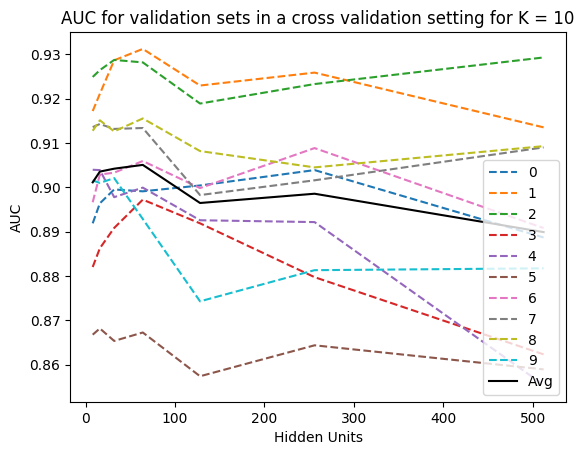

In [ ]:
plt.clf()

y = validation_values_df.columns[(validation_values_df.columns != 'Hidden_Units')]
ax = validation_values_df.plot(x='Hidden_Units', y=y, linestyle='dashed')

for line, column in zip(ax.lines, validation_values_df.columns):
    if column == 'Avg':
        line.set_linestyle('solid')
        line.set_color('black')

plt.xlabel("Hidden Units")
plt.ylabel('AUC')
plt.title('AUC for validation sets in a cross validation setting for K = 10')
plt.legend(loc='lower right')

plt.show()

In [ ]:
columns_list = [0,1,2,3,4,5,6,7,8] + ['Avg']

for column in columns_list:
    max_value = validation_values_df[column].max()
    max_row = validation_values_df[validation_values_df[column] == max_value]
    print(f"Maximum value in {column}:")
    print(max_row[[column, 'Hidden_Units']])
    print("=" * 20)

Maximum value in 0:
          0  Hidden_Units
5  0.903898           256
Maximum value in 1:
         1  Hidden_Units
3  0.93125            64
Maximum value in 2:
          2  Hidden_Units
6  0.929325           512
Maximum value in 3:
          3  Hidden_Units
3  0.897222            64
Maximum value in 4:
          4  Hidden_Units
0  0.903968             8
Maximum value in 5:
          5  Hidden_Units
1  0.868148            16
Maximum value in 6:
          6  Hidden_Units
5  0.908864           256
Maximum value in 7:
        7  Hidden_Units
1  0.9143            16
Maximum value in 8:
         8  Hidden_Units
3  0.91555            64
Maximum value in Avg:
       Avg  Hidden_Units
3  0.90507            64


In [ ]:
output = pd.read_csv('q1_2d_output.csv')
output

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,4384,4385,4386,4387,4388,4389,4390,is_positive_sentiment,pred_prob,pred_label
0,2037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.793309,1
1,1978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.297285,0
2,855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.322337,0
3,1719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.464575,0
4,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.649806,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.290453,0
236,2196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.953283,1
237,402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.455757,0
238,2341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.467727,0


In [ ]:
output = output[['Unnamed: 0', 'is_positive_sentiment',	'pred_prob', 'pred_label']]
output = output.set_index('Unnamed: 0')
output

,is_positive_sentiment,pred_prob,pred_label
Unnamed: 0,,,
2037,1,0.793309,1
1978,0,0.297285,0
855,0,0.322337,0
1719,0,0.464575,0
2019,1,0.649806,1
...,...,...,...
208,0,0.290453,0
2196,1,0.953283,1
402,1,0.455757,0


In [ ]:
x_train_df

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...
...,...,...
2395,yelp,The sweet potato fries were very good and seas...
2396,yelp,I could eat their bruschetta all day it is dev...
2397,yelp,Ambience is perfect.
2398,yelp,We ordered the duck rare and it was pink and t...


In [ ]:
result_df = output.join(x_train_df).reset_index()
result_df

,Unnamed: 0,is_positive_sentiment,pred_prob,pred_label,website_name,text
0,2037,1,0.793309,1,yelp,Very good lunch spot.
1,1978,0,0.297285,0,yelp,So don't go there if you are looking for good ...
2,855,0,0.322337,0,imdb,Avoid this film at all costs.
3,1719,0,0.464575,0,yelp,Eew... This location needs a complete overhaul.
4,2019,1,0.649806,1,yelp,And service was super friendly.
...,...,...,...,...,...,...
235,208,0,0.290453,0,amazon,"Saggy, floppy piece of junk."
236,2196,1,0.953283,1,yelp,"Great steak, great sides, great wine, amazing ..."
237,402,1,0.455757,0,amazon,The phone loads super!
238,2341,1,0.467727,0,yelp,"I was proven dead wrong by this sushi bar, not..."


In [ ]:
result_df.to_csv('q1_2d_output_final.csv')